# TN Ex 02: Predictive Coding & the Hierarchical Gaussian Filter
Spring Semester 2025

**Exercise submission deadline** (via Moodle): Tuesday 6pm, March 25, 2025.

Exercise discussion: Friday 2pm, March 28, 2025.

Please enter your exercise group (number + names of all group members): 


- Exercise group 1

- members: Lena Fiedor, Valentin Magis, Victoria Ploerer


## References

**Julia**
- The [Julia Programming Language](https://julialang.org/)
- A useful reference to help you set up your Julia environment and run an interactive notebook: https://julia.quantecon.org/getting_started_julia/getting_started.html
- Julia [Cheat Sheet](https://cheatsheet.juliadocs.org/)

**Predictive Coding**
- Bogacz et al. (2017): https://doi.org/10.1016/j.jmp.2015.11.003

**Hierarchical Gaussian Filtering**
- Mathys et al. (2011) https://doi.org/10.3389/fnhum.2011.00039 & Mathys et al. (2014) https://doi.org/10.3389/fnhum.2014.00825
- The 'generalized HGF' (Weber et al. 2023): https://doi.org/10.48550/arXiv.2305.10937
- [HierarchicalGaussianFiltering.jl package](https://github.com/ComputationalPsychiatry/HierarchicalGaussianFiltering.jl) incl [docs](https://computationalpsychiatry.github.io/HierarchicalGaussianFiltering.jl/dev/)
- [ActionModels.jl package](https://github.com/ComputationalPsychiatry/ActionModels.jl) incl [docs](https://computationalpsychiatry.github.io/ActionModels.jl/dev/)


## Setup

The `versioninfo()` function should print your Julia version and some other info about the system:

In [24]:
versioninfo()

Julia Version 1.11.3
Commit d63adeda50 (2025-01-21 19:42 UTC)
Build Info:
  Built by Homebrew (v1.11.3)

    Note: This is an unofficial build, please report bugs to the project
    responsible for this build and not to the Julia project unless you can
    reproduce the issue using official builds available at https://julialang.org/downloads

Platform Info:
  OS: macOS (arm64-apple-darwin24.2.0)
  CPU: 12 × Apple M3 Pro
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, apple-m2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 
  DYLD_FALLBACK_LIBRARY_PATH = /Users/vm/.julia/artifacts/c1600fa286afe4bf3616780a19b65285c63968ca/lib:/Users/vm/.julia/artifacts/b820a0a437e8501d06a17439abd84feaa5b6cca3/lib:/Users/vm/.julia/artifacts/5b90ad21b4b1af3a9446241fb5afe3e3b3eda941/lib:/opt/homebrew/Cellar/gcc/14.2.0_1/lib/gcc/current:/usr/lib:/Users/vm/.julia/artifacts/c99c0e2b61a41b4b2294b30e9f7f26e50c2e38eb/lib:/Users/vm/.julia/artifacts/9410bad2635eda22

Now we need to activate our project environment and load a few julia packages which are specified in the Project.toml file.

In [25]:
# running this for the first time takes a couple of mins...
using Pkg
Pkg.activate(joinpath(@__DIR__, "Project.toml"))
Pkg.instantiate()

  Activating project at `~/Desktop/Translational_Neuromodeling_Exercise_1/ex-02`


In [26]:
Pkg.add("Turing")

   Resolving package versions...
  No Changes to `~/Desktop/Translational_Neuromodeling_Exercise_1/ex-02/Project.toml`
  No Changes to `~/Desktop/Translational_Neuromodeling_Exercise_1/ex-02/Manifest.toml`


In [27]:
# load packages
using Random
using Plots
using LaTeXStrings
using Optim

using Printf
using Statistics
using LinearAlgebra

# HGF
using HierarchicalGaussianFiltering
using ActionModels
using StatsPlots
using Distributions
using CSV
using DataFrames
using LogExpFunctions
using Turing

For reproducibility purposes, we fix the seed of the random number generator.

In [28]:
# fix rng seed
rng = MersenneTwister(1234)

MersenneTwister(1234)

&nbsp;
___
___
&nbsp;

## Exercise 2.1: Speed of convergence in Predictive Coding

In this exercise, we will have a closer look on the convergence behaviour of predictive coding algorithms. We use the same model as [Bogacz (2017)](https://doi.org/10.1016/j.jmp.2015.11.003), so we have 
\begin{align}
p(x) &=  \frac{1}{\sqrt{2\pi\Sigma_{pr}}} \exp^{-\frac{(x-\mu_{pr})^2}{2\Sigma_{pr}}} \\
p(y|x) &= \frac{1}{\sqrt{2\pi\Sigma_{gen}}} \exp^{-\frac{(y - g(x))^2}{2\Sigma_{gen}}}
\end{align}  
for prior $p(x)$ and likelihood $p(y|x)$, where $g(x)=x^2$.
To enable concrete calculations, we set $\Sigma_{pr} = 1$, $\Sigma_{gen} = 1$, $\mu_{pr} = 3$. In addition, we assume that we observe $y = 2$.

We want to approximate our posterior $p(x|y)$ by a delta-distribution $q_\phi(x) = \delta(x - \phi)$. We could do that for every $\phi$, but we want to find the value $\phi_0$, s.t. the delta-distribution is nonzero at the maximum of the posterior. One can show (see Bogacz, 2017), that this is equivalent to finding the argmax of 
\begin{align}
F(x) = \ln(p(y|x)) + \ln(p(x)).
\end{align} 
Note that $F$ is only equal to the log-joint for this particular choice of $q_\phi(x)$. If we would approximate the posterior by a different function class, $F$ would have a different form

a) Plot posterior $p(x|y)$ and $F(x)$ for $x \in [0,4]$. Is the posterior normal?  *(3 points)*

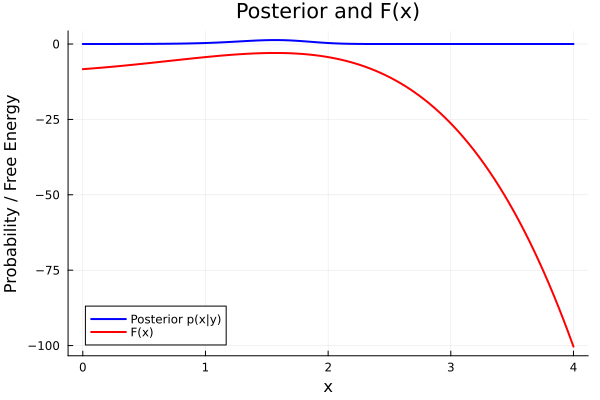

In [29]:
# define variables
var_prior = 1   # prior variance
var_gen = 1     # generative variance
mean_prior = 3  # prior mean
y = 2           # observed value

# define prior and likelihood functions
prior(x) = pdf(Normal(mean_prior, var_prior), x)
likelihood(x) = pdf(Normal(x^2, var_gen), y)

# compute posterior (unnormalized)
posterior(x) = prior(x) * likelihood(x)

# compute F(x)
# 1/sqrt(s*pi*var_prior) is a constant, so it does not affect the posterior calculations
F(x) = log(prior(x)) + log(likelihood(x))

# define the range of x values
x_vals = range(0, 4, length=100)

# compute the posterior and F(x)
posterior_vals = [posterior(x) for x in x_vals]
F_vals = [F(x) for x in x_vals]

# normalize posterior
posterior_vals /= sum(posterior_vals) * step(x_vals)

# plot results
plot(x_vals, posterior_vals, label="Posterior p(x|y)", linewidth=2, color=:blue)
plot!(x_vals, F_vals, label="F(x)", linewidth=2, color=:red)
xlabel!("x")
ylabel!("Probability / Free Energy")
title!("Posterior and F(x)")

**Is the posterior normal?**<br>
No, the posterior is not normal because $p(x|y)$ is not Gaussian due to the quadratic function $g(x)=x^2$. This is a skewed distribution.

&nbsp;
___

Our $F(x)$ is rather a $F(\phi)$. Because of our particular approximation, $x$ and the parameter $\phi$ *live* on the same scale, but for the rest of the exercise we will talk about $F(\phi)$ to remind us that we are looking for $\phi_0$, the parameter giving us the *best* approximation $q_{\phi_0}(x)$ of the posterior $p(x|y)$.

b) Determine $\phi_0$ (up to a small error) by performing a direct gradient ascent $\phi(\tau + \Delta\tau) = \phi(\tau) + \Delta \tau \cdot \frac{\text{d} F}{\text{d} \phi}$ on $F(\phi)$. Start at $\mu_{pr}$ and plot $\phi(\tau)$ against $\tau$ for some reasonable time interval.  *(3 points)*

*Hint: You can use a step size of $\Delta\tau = 0.01$.*

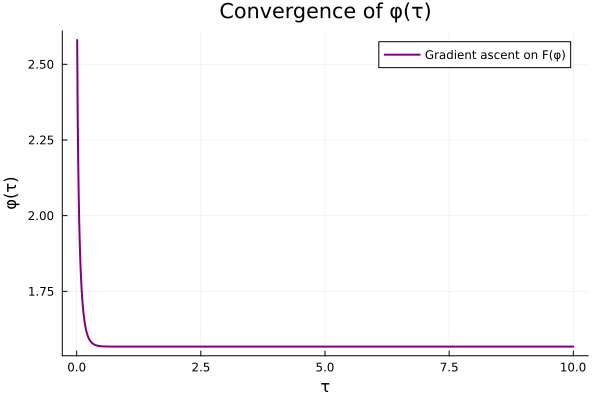

In [30]:
# define variables
step_size = 0.01
T = 10.0    # total time
num_steps = Int(T/step_size)

# define gradient function
dF(phi) = ((2 * phi * (y - phi^2)) / var_gen^2) - ((phi - mean_prior) / var_prior^2)

# perform gradient ascent
phi = mean_prior    # initial value
phi_vals = Float64[]
tau_vals = Float64[]

for i in 1:num_steps
    phi += step_size * dF(phi)
    push!(phi_vals, phi)
    push!(tau_vals, i * step_size)
end

# plot results
plot(tau_vals, phi_vals, xlabel="τ", ylabel="φ(τ)", label="Gradient ascent on F(φ)", linewidth=2, color=:purple)
title!("Convergence of φ(τ)")

&nbsp;
___

The (direct) gradient ascent allowed us to find $\phi_0$, but one can argue, that the difference/differential equation, we integrate in (b) might be too complex to be implemented neurally.

To simplify the equation, we introduce the *prediction-error*-quantities $\tilde \epsilon_{gen}$ and $\tilde \epsilon_{pr}$. To compute them, we need two additional differential equations, so that we have now three (coupled) differential equations (but with an easier structure):
\begin{align}
		\dot\phi &= \epsilon_{gen} \cdot g'(\phi) + \epsilon_{pr} \\
        \dot \epsilon_{gen} &= y - g(\phi)  - \Sigma_{gen}\cdot \epsilon_{gen} \\
        \dot \epsilon_{pr} &= \mu_{pr} - \phi - \Sigma_{pr} \cdot \epsilon_{pr}
\end{align}

c) Determine $\phi_0$ (up to a small error) by discretizing and then integrating equations the three differential equations above. Use the same step size as for (b) and plot the evolution of $\phi$, $\epsilon_{pr}$ and $\epsilon_{gen}$ against $\tau$.  *(4 points)*


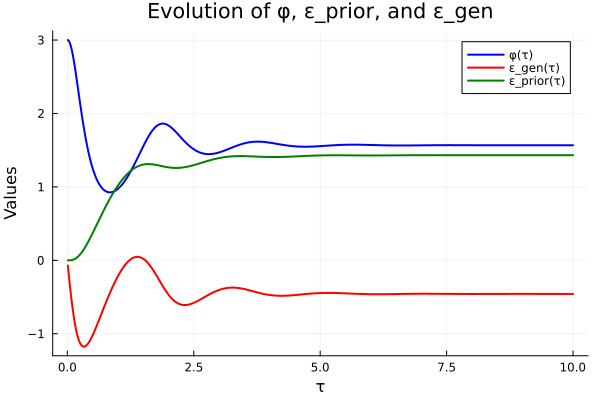

In [31]:
# define variables
phi = mean_prior
eps_prior = 0.0
eps_gen = 0.0

# store values for plotting
tau_vals = Float64[]
phi_vals = Float64[]
eps_prior_vals = Float64[]
eps_gen_vals = Float64[]

# discretized integration loop
for i in 1:num_steps
    # compute updates using Euler's method
    phi += step_size * (eps_gen * (2 * phi) + eps_prior)
    eps_gen += step_size * (y - phi^2 - var_gen * eps_gen)
    eps_prior += step_size * (mean_prior - phi - var_prior * eps_prior)

    # store values for plotting
    push!(tau_vals, i * step_size)
    push!(phi_vals, phi)
    push!(eps_prior_vals, eps_prior)
    push!(eps_gen_vals, eps_gen)

end

# plot evolution of φ, ε_gen, and ε_pr
plot(tau_vals, phi_vals, label="φ(τ)", linewidth=2, color=:blue)
plot!(tau_vals, eps_gen_vals, label="ε_gen(τ)", linewidth=2, color=:red)
plot!(tau_vals, eps_prior_vals, label="ε_prior(τ)", linewidth=2, color=:green)
xlabel!("τ")
ylabel!("Values")
title!("Evolution of φ, ε_prior, and ε_gen")

&nbsp;
___

d) Which of the two methods used in (b) and (c) converges faster? Why?  *(2 points)*

- In **Direct Gradient Ascent Model** (b), the update equation follows a direct, steepest-ascent approach on $F(x)$, therefore it moves directly in the direction of the steepest gradient. Since we explicitly compute $\frac{dF}{d\phi}$, the update moves directly toward the maximum at each step and usually converges faster, however is biologically less plausible.
- In **Prediction-Error-Based Model** (c), the update is indirect. We introduce two auxiliary differential equations for $\epsilon_{prior}$ and $\epsilon_{gen}$. These prediction error need to stabilize before $\phi$ converges ($\phi$ does not get the full gradient force on each step), which introduces additional dynamics. Introducing local error computations instead of global gradient tracking is more biologically plausible, as it resembles how real neurons process informations.

&nbsp;
___
___
&nbsp;

## 2.2 The HGF Julia Implementation and Experimental Design

This exercise is intended to get you started with the HGF Julia implementation and understand the relation between the generative model and the update equations (resulting from variational inversion of the generative model) better.

a) Briefly summarise the content and use of the two Julia packages [HierarchicalGaussianFiltering.jl](https://github.com/ComputationalPsychiatry/HierarchicalGaussianFiltering.jl) and [ActionModels.jl](https://github.com/ComputationalPsychiatry/ActionModels.jl). How are the two packages related to each other? *(2 points)*


&nbsp;
The two packages work together to model decision-making using uncertainty and volitality, but they do different things. The HGF package actually generates a perceptual HGF model to create a prediction or belief about the world. The ActionModels package uses this belief to infer an action or outcome. Together, they model how the Baysian Brain might predict and act in the world, but they each have a different role in the equation. For example, I can create an HGF model to make a prediction of whether it will rain today, using my world model and beliefs. Then, I can use my generated prediction to decide on an action: wear rain boots, or sneakers.

&nbsp;
___

In the lecture, we looked at the three level HGF for binary outcomes with perceptual parameters $\kappa$, $\omega$, and $\vartheta$. However, in the software implementation, the parameters $\kappa$ and $\omega$ exist on all levels. On the first level, $\kappa_1$ can be set to 1 to obtain the original model, and $\omega_1$ is undefined. On the highest level, $\kappa_n$ is undefined, and $\omega_n$ corresponds to our previous $\vartheta$. In symmetry to lower levels however, $\omega_3$ describes the log-variance of the Gaussian. Therefore:
\begin{equation}
  \vartheta = \exp(\omega_3)
\end{equation}
in the binary HGF with 3 levels. In this exercise, we will always provide both values to avoid confusion.

b) The Julia packages allow us to simulate beliefs (mean $\mu$, precision $\pi$) and behavior $y$ in response to sensory inputs $u$, using the perceptual model of the HGF (and an appropriate action model). But first, we take a step back and generate sensory inputs $u$ using the HGF. Write a function that implements the generative model for the three level HGF for binary outcomes and generates binary events $u$ according to it. *Hint: These equations were given in the lecture and are not implemented in the software package.*

To start, choose the following parameter setting:
\begin{equation}
  \kappa_2 = 1, \quad \omega_2 = -4, \quad \vartheta = \exp(\omega_3) = \exp(-6)
\end{equation}
You can use the following values for the initial states:
\begin{equation}
    x_2^{(0)}=0, \quad  x_3^{(0)}=1
\end{equation}
Plot the resulting traces of $x_3$, $x_2$, and the generated inputs $u$ for a given number of trials (suggestion: plot the trajectories for a trial number of 320). Repeat this procedure a few times and examine the typical traces you get. Also try out different parameter settings, in particular, higher values for $\vartheta$. What do you observe? *(4 points)*

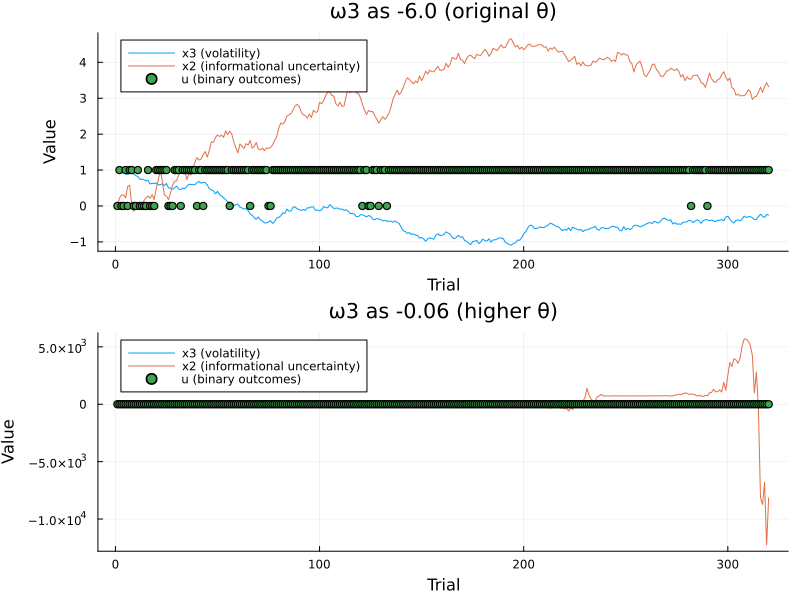

In [32]:
function simulate_hgf_binary(n_trials::Int; κ2=1.0, ω2=-4.0, ω3=-6.0, x2_0=0.0, x3_0=1.0)
    θ = exp(ω3)
    x2 = zeros(Float64, n_trials)
    x3 = zeros(Float64, n_trials)
    u = zeros(Int, n_trials)

    x2[1] = x2_0
    x3[1] = x3_0

    for k in 2:n_trials
        # Level 3: volatility with step size θ
        x3[k] = rand(Normal(x3[k-1], sqrt(θ)))

        # Level 2: tendancy towards category 1 (informational uncertainty)
        var_x2 = exp(κ2 * x3[k] + ω2)
        x2[k] = rand(Normal(x2[k-1], sqrt(var_x2)))

        # Level 1: generating binary outcome
        p = 1 / (1 + exp(-x2[k]))
        u[k] = rand(Bernoulli(p))
    end

    return x3, x2, u
end

# Simulation with ω₃ = -6.0 (original theta)
x3_a, x2_a, u_a = simulate_hgf_binary(320; ω3=-6.0)
p1 = plot(1:320, x3_a, label="x3 (volatility)", title="ω3 as -6.0 (original θ)")
plot!(p1, 1:320, x2_a, label="x2 (informational uncertainty)")
plot!(p1, 1:320, u_a, label="u (binary outcomes)", seriestype=:scatter)
xlabel!(p1, "Trial")
ylabel!(p1, "Value")

# Simulation with ω₃ = -0.06 (higher theta)
x3_b, x2_b, u_b = simulate_hgf_binary(320; ω3=-0.06)
p2 = plot(1:320, x3_b, label="x3 (volatility)", title="ω3 as -0.06 (higher θ)")
plot!(p2, 1:320, x2_b, label="x2 (informational uncertainty)")
plot!(p2, 1:320, u_b, label="u (binary outcomes)", seriestype=:scatter)
xlabel!(p2, "Trial")
ylabel!(p2, "Value")

plot(p1, p2, layout=(2,1), size=(800, 600))

&nbsp;
Increasing $\vartheta$ from exp(-6) to exp(-0.06) increases the variance and decreases stability. $\vartheta$ directly influences x3 (how volatile the world is), and indirectly influences x2 (the informational uncertainty). Just looking at the y-axis, we can see that both x3 and x2 are completely blowing up and down. The changes are so drastic, that the y-axis values must be scaled up 1000x.  

&nbsp;
___

c) Decide on one input sequence that you generated, simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model) in combination with the unit-square sigmoid action model with the same (or other) parameters that you used during input generation. Does your simulated agent correctly track the evolution of $x_3$ and $x_2$? *(3 points)*

*Hint: You can use the premade hgf `binary_3level` in combination with the premade agent `hgf_unit_square_sigmoid`.*

The following table summarises the naming conventions for parameters and states used in the HierarchicalGaussianFiltering.jl package (the greek letters correspond to the naming used in the lecture slides and in Mathys et al. [2011](https://doi.org/10.3389/fnhum.2011.00039), [2014](https://doi.org/10.3389/fnhum.2014.00825)):

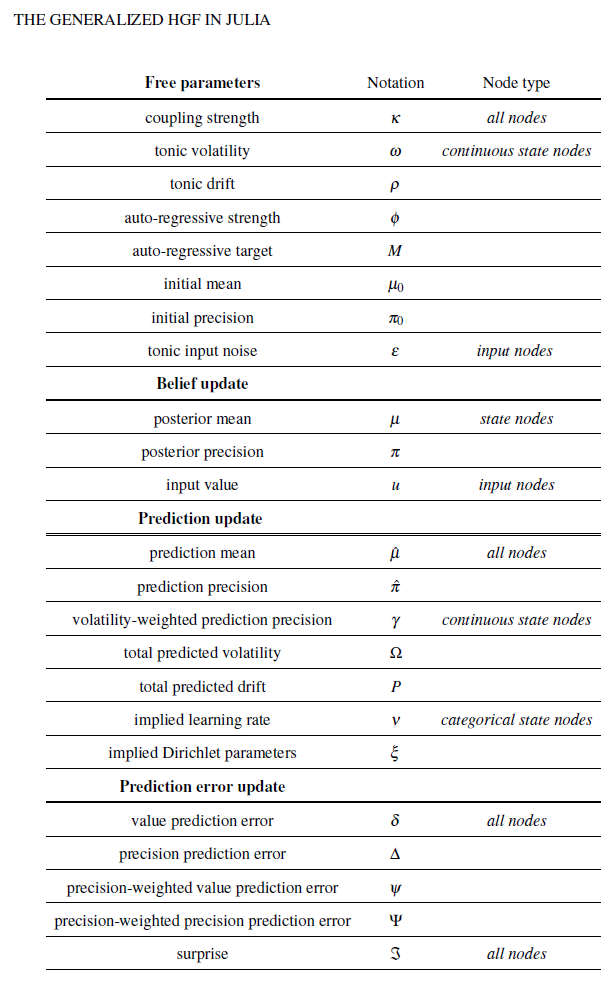

e.g., in the premade binary_3level HGF, the parameter $\kappa_2$ representing the coupling strength between the probability $x_2$ and volatility $x_3$ is referred to as ```("xprob", "xvol", "coupling_strength")``` in the code. Analogously for $\omega_2$ and ```("xprob", "volatility")```, $\mu_2^{(0)}$ and ```("xprob", "initial mean")```, ...


┌ Warning:  ("xprob", "drift") was not set by the user. Using the default: 0
└ @ ActionModels /Users/vm/.julia/packages/ActionModels/bPSgb/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("xvol", "autoconnection_strength") was not set by the user. Using the default: 1
└ @ ActionModels /Users/vm/.julia/packages/ActionModels/bPSgb/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("xprob", "autoconnection_strength") was not set by the user. Using the default: 1
└ @ ActionModels /Users/vm/.julia/packages/ActionModels/bPSgb/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("xvol", "drift") was not set by the user. Using the default: 0
└ @ ActionModels /Users/vm/.julia/packages/ActionModels/bPSgb/src/utils/warn_premade_defaults.jl:13
┌ Warning:  update_type was not set by the user. Using the default: EnhancedUpdate()
└ @ ActionModels /Users/vm/.julia/packages/ActionModels/bPSgb/src/utils/warn_premade_defaults.jl:13
┌ Warning:  save_history was not set by the user. Using the default: true

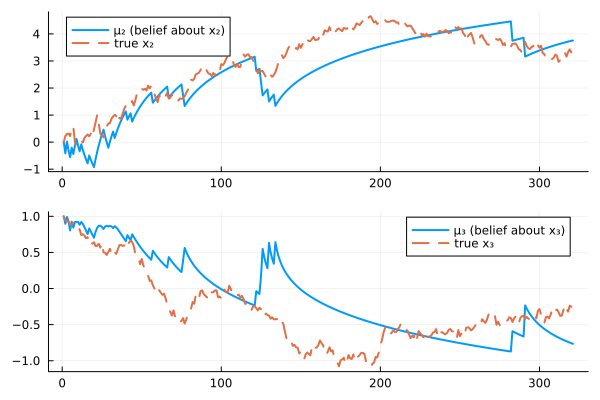

In [53]:
# using same parameters as in 2.2b
hgf_parameters = Dict(
    ("xprob", "volatility") => -4.0,
    ("xprob", "initial_mean") => 0.0,
    ("xprob", "initial_precision") => 1.0,
    ("xvol", "volatility") => exp(-6.0),
    ("xvol", "initial_mean") => 1.0,
    ("xvol", "initial_precision") => 0.01,
    ("xprob", "xvol", "coupling_strength") => 1.0,
    ("xbin", "xprob", "coupling_strength") => 1.0   
)

# creating HFG and agent with generated inputs from 2.2b
hgf = premade_hgf("binary_3level", hgf_parameters)
agent_parameter = Dict("action_noise" => 0.3)
agent = premade_agent("hgf_unit_square_sigmoid", hgf, agent_parameter)
give_inputs!(agent, u_a)

# plotting the agent's belief about x2 and x3 along with their true values
μ2 = get_history(agent, ("xprob", "posterior_mean"))
μ3 = get_history(agent, ("xvol", "posterior_mean"))

p1 = plot(μ2, label="μ₂ (belief about x₂)", lw=2)
plot!(p1, x2_a, label="true x₂", lw=2, linestyle=:dash)
p2 = plot(μ3, label="μ₃ (belief about x₃)", lw=2)
plot!(p2, x3_a, label="true x₃", lw=2, linestyle=:dash)
plot(p1, p2, layout = (2,1))


&nbsp;
The simulated agent somewhat correctly tracks both x2 and x3. However, it does a much better job of tracking x2 since it is a lower level of inference. On the other hand, the agent's beliefs about x3 less accurately track the true value of x3. 

&nbsp;
___

d) Why, do you think, would it be a good or bad idea to use the generative model of the HGF to generate stimulus sequences to use in an experiment? If you think it's a bad idea, why could it still be a useful model for the agent to invert during perception? *(2 points)*

&nbsp;
The great advantage of using a generative HGF for inferance is that it serves as a good model for how the Baysian Brain works. It captures how humans adapt to changing environments, explains behavior using internal beliefs and uncertainty, and even includes and helps us quantify surprise / volitality estimates. Lastly, the ability to use the same HGF for inference makes analysis much easier.

Using an HGF to generate stimulus sequences is also a good idea. Human cognition is likely to encounter changing probability and volatility estimates over time, and the HGF implements these realistic dynamics. Furthermore, the fact that it is a computational model allows us to manipulate certain parameters, such as $\kappa$, $\omega$, and $\vartheta$. There are some downfalls to using HGF to generate stimuli, such as the risk of overfitting to the model's assumptions of how human perception and decision making work. Still, if done carefully, HGF is a powerful tool for both generation and inference.

&nbsp;
___
___
&nbsp;

## 2.3 Coordinate Choice and Parameter Identifiability in the HGF

In this exercise, you will learn how you can build your own HGF and action models using the respective julia packages. Moreover, we take a closer look at the meaning of the perceptual parameters of the three level HGF for binary outcomes and their relationships. The observations we will make, however, generalize to any HGF with $n$ levels and both categorical as well as continuous outcomes. 

For this exercise, make use of the example binary input sequence that is contained in the `classic_binary_inputs.csv` file within the zip-folder of ex02.

&nbsp;
The two packages work together to model decision-making using uncertainty and volitality, but they do different things. The HGF package actually generates a perceptual HGF model to create a prediction or belief about the world. The ActionModels package uses this belief to infer an action or outcome. Together, they model how the Baysian Brain might predict and act in the world, but they each have a different role in the equation. For example, I can create an HGF model to make a prediction of whether it will rain today, using my world model and beliefs. Then, I can use my generated prediction to decide on an action: wear rain boots, or sneakers.

In [54]:
u3 = CSV.read(joinpath(@__DIR__, "classic_binary_inputs.csv"), DataFrame)[!, 1];

a) Simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model). with the following parameters:

\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 1&, \quad \sigma_3^{(0)} = 1, \\
  \kappa_2 = 2.5&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-6) = 0.0025,
  \end{split}
\end{equation}

in combination with the unit-square sigmoid action model with parameter: 

$$ \zeta = 5. $$

For this exercise, do **NOT** use the premade agent `binary_3level` but rather build the 3-level HGF for binary inputs on your own using the `init_hgf()` function and combine it with a unit-square sigoid action model. *(3 points)*


In [55]:
using HierarchicalGaussianFiltering
using ActionModels

In [59]:
function build_binary_3level_hgf()
    # Level-1 node: binary input
    node_u = BinaryInput("u")

    # Level-2 node: binary state
    node_xbin = BinaryState("xbin")

    # Level-3 node: continuous “probability” state
    #   ω₂ = -4   -> volatility = -4
    #   κ₂ = 2.5 -> drift = 2.5
    #   no explicit mention of the initial mean or precision in your problem for xprob, so just setting them to 0 and 1, respectively
    node_xprob = ContinuousState(
        name              = "xprob",
        volatility        = -4,    # log-vol = -4
        drift             = 0,
        autoconnection_strength = 1,
        initial_mean      = 0,
        initial_precision = 1,
    )

    # Level-4 node: continuous “volatility” state
    #   ω₃ = -6 -> volatility = -6
    #   μ₃^{(0)}=1, σ₃^{(0)}=1
    node_xvol = ContinuousState(
        name              = "xvol",
        volatility        = -6,   # log-vol
        drift             = 0,   
        autoconnection_strength = 1,
        initial_mean      = 1,    # mu_3^{(0)}
        initial_precision = 1,    # sigma_3^{(0)}
    )

    # Define the edges connecting these nodes
    edges = Dict(
        ("u",     "xbin") => ObservationCoupling(),
        ("xbin",  "xprob") => ProbabilityCoupling(2.5), # κ₂ = 2.5
        ("xprob", "xvol")  => VolatilityCoupling(),
    )

    hgf = init_hgf(
        nodes = [node_u, node_xbin, node_xprob, node_xvol],
        edges = edges,
        node_defaults = NodeDefaults(update_type = EnhancedUpdate()),
        save_history  = true,
    )

    return hgf
end


# build the 3-level HGF
hgf = build_binary_3level_hgf()

┌ Warning: No update order specified. Using the order in which nodes were inputted
└ @ HierarchicalGaussianFiltering /Users/vm/.julia/packages/HierarchicalGaussianFiltering/4FcOu/src/create_hgf/init_hgf.jl:148


-- HGF struct --
Number of input nodes: 1
(0 continuous, 1 binary and 0 categorical)
Number of state nodes: 3
(2 continuous, 1 binary, and 0 categorical)


In [60]:
config = Dict(
   "HGF" => hgf,               # attach HGF
   "action_noise" => 5,        # sets zeta=5
   "target_state" => ("xbin","prediction_mean")
)

agent_binary_3_level = premade_agent("hgf_unit_square_sigmoid", config, verbose=true)

# 2) Run the agent on the input sequence
give_inputs!(agent_binary_3_level, u3)

320-element Vector{Bool}:
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 ⋮
 1
 0
 0
 0
 0
 1
 0
 1
 1

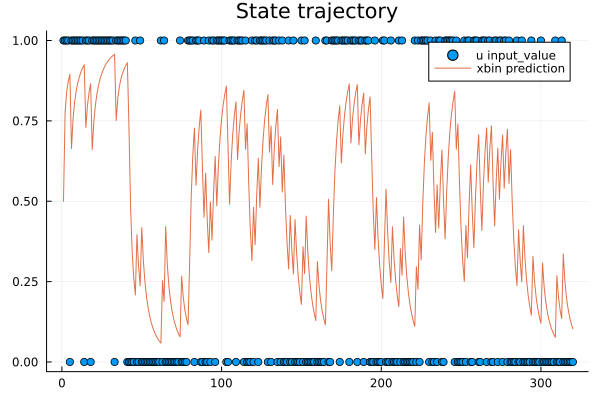

In [61]:
plot_trajectory(agent_binary_3_level, ("u", "input_value"))
plot_trajectory!(agent_binary_3_level, ("xbin", "prediction"))

&nbsp;
___

b) Try to recover the parameters you used to simulate beliefs and responses using the function `fit_model`, estimating $\zeta$, $\mu_3^{(0)}$, $\kappa_2$, and $\vartheta = \exp(\omega_3)$. You can use the following marginal priors on the free parameters:
\begin{align}
    p(\mu_3^{(0)}) &= \mathcal N(1,0.5) \\
    p(\kappa_2) &= \mathcal N(2.5,0.5) \\
    p(\omega_3) &= \mathcal N(-6,0.5) \\
    p(\zeta) &= \mathcal N(5,1) \\
\end{align}

Inspect the fit of the model and compare the posterior to the chosen prior. What do you observe? *(2 points)*


In [39]:
import ActionModels: single_agent_population_model, create_model

In [63]:
# 1) Extract the agent's history of actions:
actions = get_history(agent_binary_3_level, "action")  # returns a Vector of the action(s)

# skip the first missing element
actions = actions[2:end] 

# cast from Any to boolean
actions = Bool.(actions)

# 2) Bundle into a DataFrame:
df = DataFrame(u = u3[1:length(actions)], action = actions)

# 3) Specify priors for the parameters you want to estimate:
using Distributions
prior_2 = Dict(
    # example: top-level initial mean
    ("xvol","initial_mean") => Normal(1.0, sqrt(0.5)),  
    # second-level drift
    (("xbin","xprob","coupling_strength")) => Normal(2.5, sqrt(0.5)), 
    # top-level log-vol
    ("xvol","volatility")   => Normal(-6.0, sqrt(0.5)),
    "action_noise"          => Normal(5, 1)
)

# 4) Build a “population model” with single-agent prior:
pop_model = single_agent_population_model(prior_2)

# 5) Create a full Turing model from your agent + data:
model = create_model(agent_binary_3_level, pop_model, df, input_cols = "u", action_cols = "action", grouping_cols = String[])

# 6) Fit the model:
using Turing
fit_results = fit_model(model; 
                        n_iterations=2000,
                        n_chains=1,
                        show_progress=true)

# # 7) Inspect results:
println(fit_results.chains)
describe(fit_results.chains)

Sampling (Chain 1 of 1)   0%|                           |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/vm/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling (Chain 1 of 1)   0%|▏                          |  ETA: 0:25:06
Sampling (Chain 1 of 1)   1%|▎                          |  ETA: 0:13:04
Sampling (Chain 1 of 1)   2%|▍                          |  ETA: 0:09:09
Sampling (Chain 1 of 1)   2%|▌                          |  ETA: 0:07:00
Sampling (Chain 1 of 1)   2%|▋                          |  ETA: 0:05:46
Sampling (Chain 1 of 1)   3%|▊                          |  ETA: 0:04:53
Sampling (Chain 1 of 1)   4%|█                          |  ETA: 0:04:20
Sampling (Chain 1 of 1)   4%|█▏                         |  ETA: 0:03:52
Sampling (Chain 1 of 1)   4%|█▎                         |  ETA: 0:03:59
Sampling (Chain 1 of 1)   5%|█▍                         |  ETA: 0:03:49
Sampling (Chain 1 of 1)   6%|█▌                         |  ETA: 0:03:34
Sampling (Chain 

MCMC chain (2000×16×1 Array{Float64, 3}

)


2-element Vector{ChainDataFrame}:
 Summary Statistics (4 x 8)
 Quantiles (4 x 6)

In [64]:
fit_results.chains[1]

┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472


Chains MCMC chain (1×16×1 Array{Float64, 3}):

Iterations        = 1001:1:1001
Number of chains  = 1
Samples per chain = 1
Wall duration     = 54.94 seconds
Compute duration  = 54.94 seconds
parameters        = parameters[("xvol", "initial_mean")], parameters[("xbin", "xprob", "coupling_strength")], parameters[("xvol", "volatility")], parameters["action_noise"]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
                                          parameters      mean       std       ⋯
                                              Symbol   Float64   Float64   Flo ⋯

                parameters[("xvol", "initial_mean")]    0.8719       NaN       ⋯
  parameters[("xbin", "xprob", "coupling_strength")]    3.6903       NaN       ⋯
                  parameters[("xvol", "volatility")]   -6.5223       NaN       ⋯
      

## Original parameters for reference: 

\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 1&, \quad \sigma_3^{(0)} = 1, \\
  \kappa_2 = 2.5&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-6) = 0.0025,
  \end{split}
\end{equation}

$$ \zeta = 5. $$

## Comparison to model estimate

Comparing the original Hierarchical Gaussian Filter (HGF) parameters with the model estimates from the MCMC chain, we observe several deviations. The initial mean parameter, originally set as $\mu_3^{(0)} = 1$, was estimated at approximately 0.872, showing a slight downward shift from its original value. More notably, the coupling strength, originally represented by $\kappa_2 = 2.5$, appears significantly elevated at 3.6903, indicating a stronger inferred coupling in the fitted model compared to the original specification. The volatility parameter estimate of approximately -6.5223 closely aligns with the original logarithmic volatility $\omega_3 = -6$, corresponding to an original volatility of $\vartheta = 0.0025$. This minor deviation suggests a marginally lower estimated volatility than originally defined. Lastly, the action noise parameter, originally set as $\zeta = 5$, was estimated slightly lower at about 4.6338, reflecting reduced inferred action noise in the fitted model. Overall, the model-fitting results indicate reasonable alignment with the original parameters, though with notable deviations in coupling strength and action noise.

&nbsp;
___

c) Again, simulate beliefs and responses using your implementation of the 3-level HGF for binary inputs alongside the unit-square sigmoid action model, now with percetpual parameters:
\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 2.5&, \quad \sigma_3^{(0)} = 6.25, \\
  \kappa_2 = 1&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-4.1674) = 0.0155,
  \end{split}
\end{equation}
and action model parameter:
\begin{equation}
  \zeta = 5.
\end{equation}
Compare the belief trajectories with the ones you simulated in (a). What do you find? Can you explain this effect? *(2 points)*

In [65]:
function build_binary_3level_hgf_new_params()
    # Level-1 node: binary input
    node_u = BinaryInput("u")

    # Level-2 node: binary state
    node_xbin = BinaryState("xbin")

    # Level-3 node: continuous “probability” state
    #   ω₂ = -4   -> volatility = -4
    #   κ₂ = 2.5 -> drift = 2.5
    #   no explicit mention of the initial mean or precision in your problem for xprob, so just setting them to 0 and 1, respectively
    node_xprob = ContinuousState(
        name              = "xprob",
        volatility        = -4,    # log-vol = -4
        drift             = 0,
        autoconnection_strength = 1,
        initial_mean      = 0,
        initial_precision = 1,
    )

    # Level-4 node: continuous “volatility” state
    #   ω₃ = -6 -> volatility = -6
    #   μ₃^{(0)}=1, σ₃^{(0)}=1
    node_xvol = ContinuousState(
        name              = "xvol",
        volatility        = -4.1674,   # log-vol
        drift             = 0,   
        autoconnection_strength = 1,
        initial_mean      = 2.5,    # mu_3^{(0)}
        initial_precision = 6.25,    # sigma_3^{(0)}
    )

    # Define the edges connecting these nodes
    edges = Dict(
        ("u",     "xbin") => ObservationCoupling(),
        ("xbin",  "xprob") => ProbabilityCoupling(1), # κ₂ = 1
        ("xprob", "xvol")  => VolatilityCoupling(),
    )

    hgf = init_hgf(
        nodes = [node_u, node_xbin, node_xprob, node_xvol],
        edges = edges,
        node_defaults = NodeDefaults(update_type = EnhancedUpdate()),
        save_history  = true,
    )

    return hgf
end

# build the 3-level HGF
hgf_2 = build_binary_3level_hgf_new_params()

config = Dict(
   "HGF" => hgf_2,                 # attach your HGF
   "action_noise" => 5,        # sets zeta=5
   "target_state" => ("xbin","prediction_mean")
)

agent_binary_3_level_2 = premade_agent("hgf_unit_square_sigmoid", config, verbose=true)

# 2) Run the agent on the input sequence
give_inputs!(agent_binary_3_level_2, u3)

┌ Warning: No update order specified. Using the order in which nodes were inputted
└ @ HierarchicalGaussianFiltering /Users/vm/.julia/packages/HierarchicalGaussianFiltering/4FcOu/src/create_hgf/init_hgf.jl:148


320-element Vector{Bool}:
 0
 1
 0
 1
 1
 1
 0
 0
 1
 1
 ⋮
 0
 0
 0
 0
 1
 1
 1
 1
 0

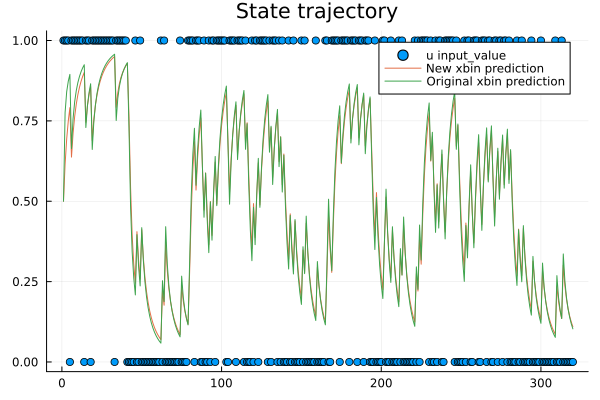

In [66]:
plot_trajectory(agent_binary_3_level_2, ("u", "input_value"))
plot_trajectory!(agent_binary_3_level_2, ("xbin", "prediction"), label="New xbin prediction")
plot_trajectory!(agent_binary_3_level, ("xbin", "prediction"), label="Original xbin prediction")

The predictions seem not to have changed much. 

&nbsp;
___

d) By setting $\kappa_2$ to 1 and/or $\omega_2$ to 0, we can make these parameters seemingly disappear from the model. Try to write down a rule for how you would have to change the other parameters such that only $\mu_3$ is affected by this change, but the belief trajectories on the lower levels stay the same. What does that tell you? *(2 points)*


We consider the 3-level Hierarchical Gaussian Filter (HGF) where the second-level variance is given by:

$$
f_2(x_3) = \exp\bigl(\kappa_2,x_3 + \omega_2\bigr).
$$

If we set $\kappa_2 = 1$ and/or $\omega_2 = 0$, we can effectively absorb these parameters into $x_3$ by defining a new top-level state:

$$
x_3^{*} = \kappa_2,x_3 + \omega_2.
$$

Then:

$$
\exp(\kappa_2,x_3 + \omega_2) = \exp\bigl(x_3^{*}\bigr),
$$

which preserves the same variance coupling at Level 2.

Why does this matter?
- Changing $\kappa_2$ and $\omega_2$ but redefining $x_3$ in this way leaves the lower-level belief trajectories (Levels 1 and 2) unchanged.
- These parameters and the new state $x_3^{*}$ are simply shifting and rescaling the coordinate system of the top-level state.
- Hence, if only data from the lower levels are observed, $\kappa_2$ and $\omega_2$ are not identifiable because they can always be traded off against the definition of $x_3$.

In practical terms, to estimate or pin down $\kappa_2$ or $\omega_2$ separately, one needs additional constraints or data anchoring $x_3$. Otherwise, changes in $\kappa_2$ or $\omega_2$ just relabel how $x_3$ is measured, without changing lower-level predictions.


&nbsp;
___

e) We can actually get rid of the indeterminacy observed in (b) and (c) by including a readout of $\mu_3$ in our action model. This way, we can estimate all three, $\mu_3^{(0)}$, $\kappa_2$, and $\omega_2$, given observed responses. Try this by creating a new variant of the unit-square sigmoid action model, where $\mu_3$ determines the trial-by-trial decision temperature:

$$ p(y=1|\hat{\mu}_1, \mu_3) = \frac{\hat{\mu}_1^{\exp(-\mu_3)}}{\hat{\mu}_1^{\exp(-\mu_3)} + (1-\hat{\mu}_1)^{\exp(-\mu_3)}} $$

This means that agents will behave less deterministically the more volatile they believe the environment to be.

Repeat the exercise of (a) with the new action model. *(3 points)*

In [45]:
# insert your solution here ...